In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil

#### Evaluate the impact of read depth on the stability of the results 
--> how much do the results (mut rate, mut spectrum) fluctuate with decreasing read depth --> evaluate variability between samples using random downsampling 

In [2]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

# correct the sequence
# LOV_gene_corrected = list(LOV_gene)
# LOV_gene_corrected[413] = "A"
# LOV_gene_corrected = "".join(LOV_gene_corrected)

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end_corr = "GAAAACATTGATGAAGCGGCCAAA"
LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [10]:
def find(string, value_list):
    indexes = [string.find(letter) for letter in value_list]
    try: 
        ind = min([index for index in indexes if index != -1])
    except:
        ind = 400 #250
    return ind

def read_sequences(variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False):
    """
    read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
    arbitrary_cutoff_a: at which position to arbitrary cut off the forward reads that already went through the quality score filter (= max length of the reads)
    arbitrary_cutoff_b: at which position to arbitrary cut off the backward reads that already went through the quality score filter (= max length of the reads)
    returns list of sequences
    """
    a_sequences = []
    b_sequences = []
    quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']

    with open(f'{base_dir}/data/fastq/{variant}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{variant}_R2_001.fastq', "rt") as b_file:

        a_reader = QualityIO.FastqGeneralIterator(a_file)
        b_reader = QualityIO.FastqGeneralIterator(b_file)
        
        for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
                a_id, a_seq, a_qual = a
                b_id, b_seq, b_qual = b
                cutoff_a = find(a_qual, quality_score)
                cutoff_b = find(b_qual, quality_score)

                if arbitrary_cutoff_a and catch_left in a_seq: # cut off a_seq to an (arbitrary) chosen maximum length (=arbitrary_cutoff_a)
                    if cutoff_a > (a_seq.index(catch_left) + arbitrary_cutoff_a):
                        cutoff_a = a_seq.index(catch_left)  + len(catch_left) + arbitrary_cutoff_a 
                
                if arbitrary_cutoff_b and dna_rev_comp(catch_right) in b_seq: 
                    if cutoff_b > (b_seq.index(dna_rev_comp(catch_right)) + arbitrary_cutoff_b):
                        cutoff_b =b_seq.index(dna_rev_comp(catch_right))+ len(catch_right) + arbitrary_cutoff_b

                a_sequences.append(a_seq[:cutoff_a])
                b_sequences.append(b_seq[:cutoff_b])
        print("total reads", total_read+1)

    return a_sequences, b_sequences


def read_filtering(a_seqs, b_seqs, catch_left = catch_left, catch_right = catch_right, n_mut_treshold = 10, ref_gene = LOV_gene): 
    """
    filter out reads with more than n_mut_treshold mutations to get rid of reads with indels that lead to frameshifts and scew the results (as we are here only interested in mutations)
    """

    a_sequences = []
    b_sequences = []

    for a_seq, b_seq in zip(a_seqs, b_seqs):
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                total_muts_a = sum([ref_gene[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= n_mut_treshold: 
                    a_sequences.append(a_seq)
                else: 
                    a_sequences.append("")
            else: 
                a_sequences.append("")
                     
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                total_muts_b = sum([ref_gene[::-1][idx] != gene_b[::-1][idx] for idx in range(len(gene_b))])

                if total_muts_b <= n_mut_treshold:
                    b_sequences.append(b_seq)
                else:
                    b_sequences.append("")
            else: 
                b_sequences.append("")

    print("total forward reads after filtering", sum([a_seq != "" for a_seq in a_sequences]))
    print("total reverse reads after filtering", sum([b_seq != "" for b_seq in b_sequences]))
    return a_sequences, b_sequences


def gather_AA_variants(a_seq, b_seq,use_backward_read=True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right, ref_prot = LOV):
    """
    returns a dictionary with the counts of each amino acid at each position
    n_mut_treshold: maximum number of mutations allowed (to filter out reads with indels leading to frameshifts that scew the results, as we are only interested in mutations)

    """
    mutation_dict = {}
    catch_length = len(catch_left)
    
    for idx in range(len(ref_prot)):
        mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                            'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                            'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                            'W':0, 'Y':0, '*':0, 'wt':0}
    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read:
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                tr_a = translate_dna2aa(gene_a)

                for idx, pos in enumerate(tr_a):
                    mutation_dict[idx][pos] += 1

        if use_backward_read: 
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                tr_b = translate_dna2aa(gene_b)
                tr_b = tr_b[::-1]
            
                for idx, pos in enumerate(tr_b):
                    mutation_dict[len(ref_prot)-idx-1][pos] += 1
    return mutation_dict

def gather_codon_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right, codons = codons):
    """
    returns a dictionary with the counts of each codon at each position
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    for idx in range(0, gene_len//3):
        mutation_dict[idx] = {codon: 0 for codon in codons}

    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]

                for i in range(0,len(gene_a)//3*3,3): # triplets
                    mutation_dict[i//3][gene_a[i:i+3]] += 1

        if use_backward_read:
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
             
                codons = [gene_b[i:i+3] for i in range(0,len(gene_b),3)]
                if len(gene_b) >= 3:
                    for idx in range(len(codons)): # triplets 
                        codon = codons[-idx-1]
                        if codon:
                            mutation_dict[len(mutation_dict)-idx-1][codon] += 1 # start from the end and update the mutation_dict for each triplet

    return mutation_dict



def gather_nt_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    returns a dictionary with the counts of each nt at each position
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    for idx in range(gene_len):
        mutation_dict[idx] = {'A':0, 'T':0, 'G':0, 'C':0}

    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]

                for idx, pos in enumerate(gene_a):
                    mutation_dict[idx][pos] += 1

        if use_backward_read:
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])

                gene_b = gene_b[::-1]
                for idx, pos in enumerate(gene_b):
                    mutation_dict[gene_len-idx-1][pos] += 1

    return mutation_dict


def process_reads(AA_sequence,use_backward_read = True, use_forward_read = True, arbitrary_cutoff_a = False, arbitrary_cutoff_b= False, variants = None, filter_for_n_mut = True, n_mut_treshold=10):
    """
    process reads for given variants
    use_backward_read: whether or not to use the backward read
    arbitrary_cutoff: where to cut off the forward sequence (maximum length of the reads, otherwise the cutoff is determined by the quality score = 1% error rate)
    if variants = None, all variants stored in the fastq folder are processed
    """
    variants_dict = {}
    path = f'{base_dir}/data/fastq'
    filenames = glob.glob(f'{path}/*')

    if variants is not None: # filter filenames for given variants
        filenames = [path for path in filenames if any(variant in path for variant in variants)]

    for name in filenames: 
        if '_R1' in name:
            name = name.split('/')[-1].split('_R')[0]
            f1 = name
            a_seq, b_seq = read_sequences(f1, arbitrary_cutoff_a = arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b)
            if filter_for_n_mut:
                a_seq, b_seq = read_filtering(a_seq, b_seq, n_mut_treshold = n_mut_treshold)
            variants_dict[name] = {}
            variants_dict[name] = get_variants(a_seq,b_seq,use_backward_read=use_backward_read,use_forward_read=use_forward_read)

            print(f'Done: {name}')

        # with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
        #     pkl.dump(variants_dict, handle)
    return variants_dict

def get_variants(a_seq,b_seq,use_backward_read=True,use_forward_read=True):
    
    variants_dict = {}
    variants_dict["AA"] = gather_AA_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["DNA"] = gather_nt_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["Codons"] = gather_codon_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)

    return variants_dict



def mutation_rate_vs_read_depth(a_seq, b_seq, percs , name, n_perms = 30, fig_folder = None, use_backward_read = False):
    total_reads = len(a_seq)
    coverages_dict = {}
    mut_rates_AA_dict = {}
    mut_rates_DNA_dict = {}

    for perc in percs:  
        perc= round(perc,2) 
        coverages = []
        mut_rate_AAs = []
        mut_rate_DNAs = []

        for n_perm in range(n_perms): 
            a_seq_frac = np.random.choice(a_seq, round(perc * total_reads), replace=False)
            b_seq_frac = np.random.choice(b_seq, round(perc * total_reads), replace=False)
            frac_variants = get_variants(a_seq_frac, b_seq = b_seq_frac, use_backward_read = use_backward_read, use_forward_read = True)
            frac_variants["DNA"] = pd.DataFrame.from_dict(frac_variants["DNA"])
            frac_variants["DNA"] = frac_variants["DNA"].loc[:,frac_variants["DNA"].sum() > 0]
            frac_variants["AA"] = pd.DataFrame.from_dict(frac_variants["AA"])
            frac_variants["AA"] = frac_variants["AA"].loc[:,frac_variants["AA"].sum() > 0]
            
            coverage = frac_variants['DNA'].sum().sum()/(frac_variants['DNA'].max().max()*frac_variants['DNA'].shape[1])*100

            mut_rate_AA = frac_variants['AA'].max()/frac_variants['AA'].sum()-1
            mut_rate_AA = abs(mut_rate_AA.sum())

            mut_rate_DNA = frac_variants['DNA'].max()/frac_variants['DNA'].sum()-1
            mut_rate_DNA = abs(mut_rate_DNA.sum()) #round(mut_rate/coverage*100,2)

            coverages.append(coverage)
            print(coverage)
            mut_rate_AAs.append(mut_rate_AA)#round(mut_rate_AA/coverage*100,2))
            mut_rate_DNAs.append(mut_rate_DNA)#round(mut_rate_DNA/coverage*100,2))

        coverages_dict[perc] = coverages
        mut_rates_AA_dict[perc] = mut_rate_AAs
        mut_rates_DNA_dict[perc] = mut_rate_DNAs

    ## plot
    plt.figure(figsize=(10,5))
    sns.stripplot(data=mut_rates_DNA_dict,  alpha=0.5, color="tab:blue")
    sns.stripplot(data=mut_rates_AA_dict,  alpha=0.5, color="tab:orange")
    plt.ylim(0)

    blue_patch = Line2D([0], [0], label='DNA', marker='o', markersize=5,linestyle='', color = "tab:blue", alpha = 0.7)
    orange_patch = Line2D([0], [0], label='AA', marker='o', markersize=5, linestyle='', color = "tab:orange", alpha = 0.7)
    plt.legend(handles =[orange_patch, blue_patch],  loc = "upper right", frameon = False)
    plt.xlabel("Read depth (proportion of total reads)")
    plt.ylabel("Mutation rate (# mutations per sequence)")
    plt.title(name)
    if fig_folder: 
        plt.savefig(f"{fig_folder}/{name}_mutation_rate_vs_read_depth.pdf")
    plt.show()

    return coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict

            
def calc_mut_spectrum_vs_read_depth(a_seq,b_seq, reference_seq, use_backward_read = False, use_forward_read= True, prop = 0.5, n_perms = 30): 
    mut_spec_diff_sum = pd.DataFrame(0, index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"]) 
    mean_diffs = []

    ## calculate "reference" mutagenic spectrum
    _, mut_spec_perc_ref = mut_spectrum(a_seq=a_seq, b_seq=b_seq, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
    mut_spec_perc_ref = pd.DataFrame.from_dict(mut_spec_perc_ref)

    for n_perm in range(n_perms):
    
        a_seq_frac = np.random.choice(a_seq, round(prop * len(a_seq)), replace=False)
        b_seq_frac = np.random.choice(b_seq, round(prop * len(b_seq)), replace=False)
        _, mut_spec_perc_frac = mut_spectrum(a_seq = a_seq_frac, b_seq = b_seq_frac, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
        mut_spec_perc_frac = pd.DataFrame.from_dict(mut_spec_perc_frac)

        # calculate difference between the two mutagenic spectra
        mut_spec_diff = (mut_spec_perc_frac - mut_spec_perc_ref)**2
        mean_diff = mut_spec_diff.mean().mean()
        mean_diffs.append(mean_diff)

        # calculate the sum of the squared differences over all permutations
        mut_spec_diff_sum = mut_spec_diff_sum + mut_spec_diff

    # calculate the average of the squared differences per nt conversion
    mut_spec_diff_mse = mut_spec_diff_sum/n_perms

    return mut_spec_diff_mse, mean_diffs



### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right, treshold = 10):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
            
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]

                for idx, nt in enumerate(gene_b):
                    if reference_seq[::-1][idx] != nt:
                        mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc



def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()

### Impact of read depth on mutation rate?

total reads 59259
85.51215949127781
87.6213297216579
86.47493011879804
86.60589587200566
86.6059203799026
87.1238507301244
85.2822400713967
85.31314223904813
86.17601246105919
85.25861585878397
87.06215476949225
85.97365675562713
86.36185535417214
86.89997404236416
86.00744199398464
86.45899983895048
87.04204439567712
86.82701850534433
86.94065038510799
86.42885589122147
86.75091038632046
87.05444903917737
86.25160638717642
87.08309554121486
86.62094085974917
86.6632222312148
86.44966863494494
86.23579295163182
86.1158318249006
86.75533218255765
86.76627292323926
86.3835795195534
86.47939492465744
86.82069042086509
86.22755938012686
86.33207580113567
86.36137369163193
86.15521534046155
86.14457099253644
86.46443904865671
86.40194861853476
86.17067816664591
86.38430467864156
86.37608159803925
86.23983014817077
86.37590967339013
86.32090164557155
86.20608138057386
86.25524881962781
86.3775351302722
86.28682669106263
86.30263449604072
86.33159211051017
86.27293313010834
86.3244145275908
8

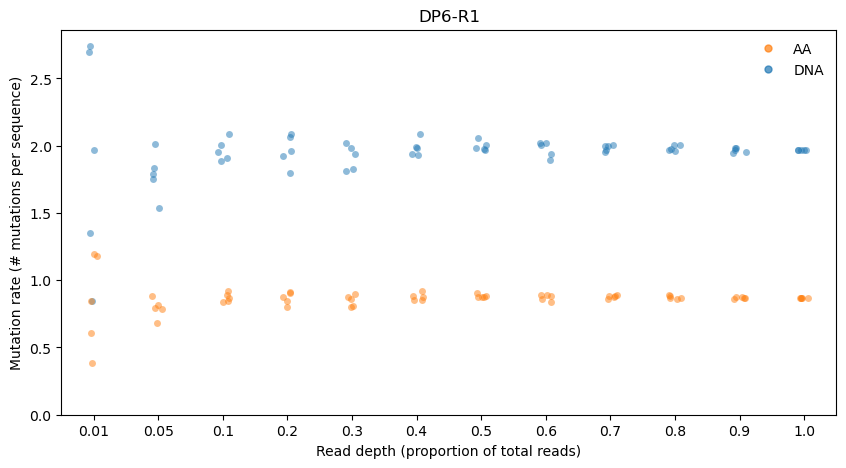

In [5]:
### randomly sample down the reads --> impact on mutation rate?
variant = "DP6"
name = "DP6-R1"
FigFolder = None #f"{base_dir}/figures/impact_of_read_depth/{name}"

a_seq, b_seq = read_sequences(variant)
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]

coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict =  mutation_rate_vs_read_depth(a_seq=a_seq, b_seq=b_seq, percs = percs, n_perms = 5, fig_folder = FigFolder, name = name, use_backward_read=False)


In [9]:
mut_spec_diff_mse, _= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = 0.3, n_perms = 5)

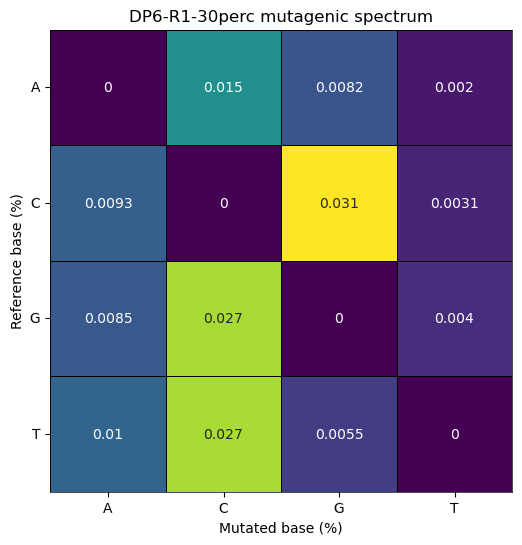

In [11]:
plot_mutation_spectrum(mut_spec_diff_mse, f"{variant}-R1-30perc", fig_folder =FigFolder)

In [13]:
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]
mean_diffs_dict = {}

for  perc in percs: 
    _, mean_diffs= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = perc, n_perms = 5)
    mean_diffs_dict[round(perc, 2)] = mean_diffs


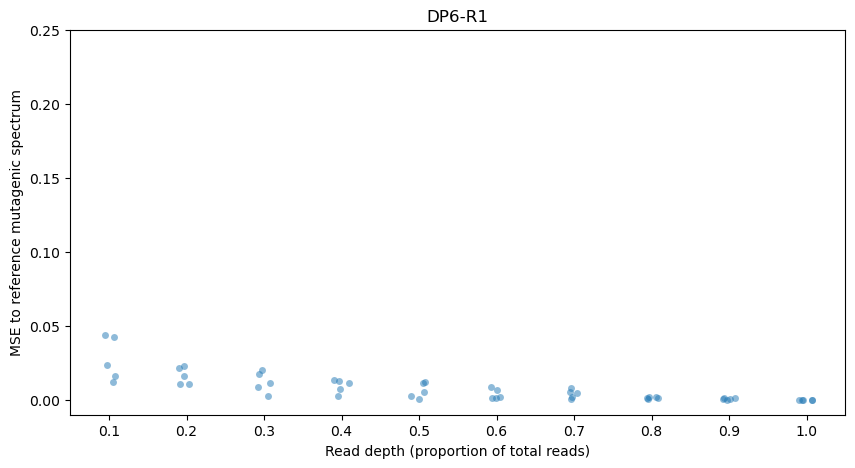

In [15]:
plt.figure(figsize=(10,5))
sns.stripplot(data=mean_diffs_dict,  alpha=0.5, color="tab:blue")
plt.ylim(-0.01, 0.25)
plt.xlim(1.5)
plt.xlabel("Read depth (proportion of total reads)")
plt.ylabel("MSE to reference mutagenic spectrum")
plt.title(name)
#plt.savefig(f"{FigFolder}/{name}_mutation_rate_vs_read_depth_from10perc.pdf")
plt.show()

In [16]:
## how many A, C, G, T are in the reference sequence
for nt in set(LOV_gene): 
    print(nt, LOV_gene[-20:].count(nt))


C 4
A 7
G 6
T 3
